In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [2]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,01/03/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,01/04/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,01/05/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,01/06/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,01/09/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
#keras only takes numpy array
training_set = dataset_train.iloc[:, 1: 2].values


In [4]:
training_set.shape

(1509, 1)

In [5]:
sc = MinMaxScaler(feature_range = (0, 1))
#fit: get min/max of train data
training_set_scaled = sc.fit_transform(training_set)

In [6]:
## 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60: i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [7]:
X_train.shape

(1449, 60)

In [8]:
y_train.shape

(1449,)

In [9]:
X_train = np.reshape(X_train, newshape = 
                     (X_train.shape[0], X_train.shape[1], 1))

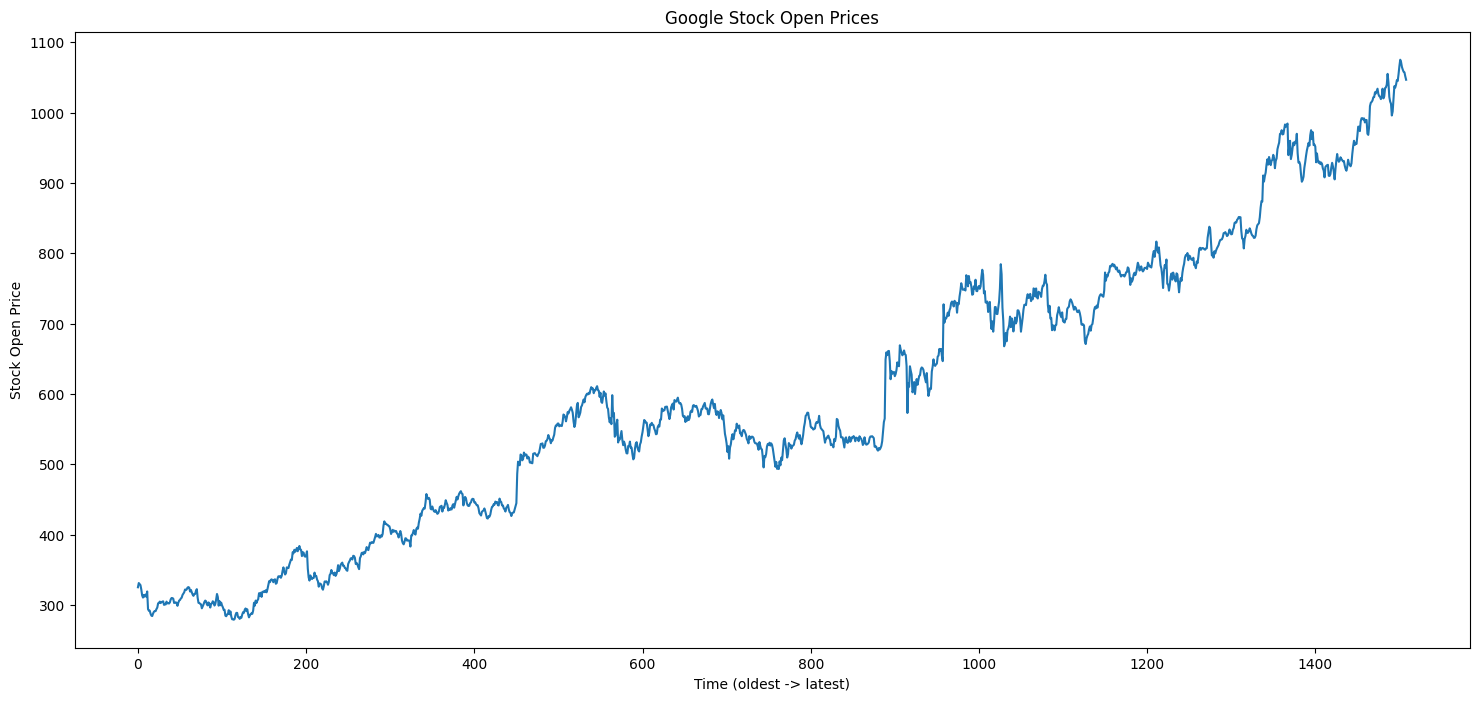

In [10]:
plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Open'])
plt.title("Google Stock Open Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Open Price")
plt.show()

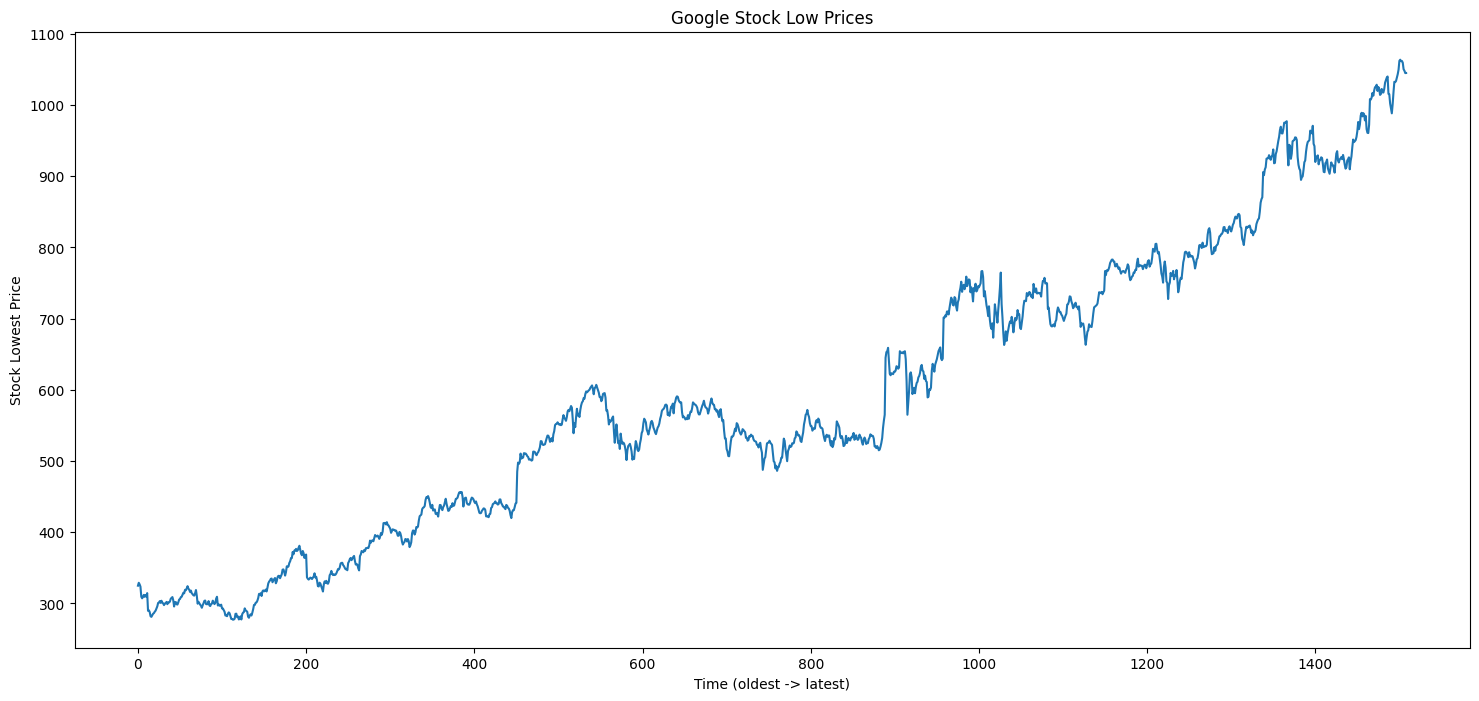

In [11]:
plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Low'])
plt.title("Google Stock Low Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Lowest Price")
plt.show()

In [12]:
regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))

##add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

##add output layer
regressor.add(Dense(units = 1))

In [13]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [14]:
regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 20)

Epoch 1/20

46/46 [==============================] - 21s 87ms/step - loss: 0.0241
Epoch 2/20
46/46 [==============================] - 4s 92ms/step - loss: 0.0037
Epoch 3/20
46/46 [==============================] - 5s 101ms/step - loss: 0.0034
Epoch 4/20
46/46 [==============================] - 4s 84ms/step - loss: 0.0035
Epoch 5/20
46/46 [==============================] - 4s 90ms/step - loss: 0.0031
Epoch 6/20
46/46 [==============================] - 5s 105ms/step - loss: 0.0034
Epoch 7/20
46/46 [==============================] - 5s 106ms/step - loss: 0.0030
Epoch 8/20
46/46 [==============================] - 5s 112ms/step - loss: 0.0029
Epoch 9/20
46/46 [==============================] - 4s 94ms/step - loss: 0.0032
Epoch 10/20
46/46 [==============================] - 4s 97ms/step - loss: 0.0026
Epoch 11/20
46/46 [==============================] - 4s 98ms/step - loss: 0.0029
Epoch 12/20
46/46 [==============================] - 4s 88ms/step - loss: 0.0024
Epoch 13/20
46/46 [============

In [15]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')

In [16]:
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,02/01/2018,1048.339966,1066.939941,1045.229980,1065.000000,1237600
1,03/01/2018,1064.310059,1086.290039,1063.209961,1082.479980,1430200
2,04/01/2018,1088.000000,1093.569946,1084.001953,1086.400024,1004600
3,05/01/2018,1094.000000,1104.250000,1092.000000,1102.229980,1279100
4,08/01/2018,1102.229980,1111.270020,1101.619995,1106.939941,1047600


In [17]:
#keras only takes numpy array
real_stock_price = dataset_test.iloc[:, 1: 2].values
real_stock_price.shape

(125, 1)

In [18]:
#vertical concat use 0, horizontal uses 1
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), 
                          axis = 0)
##use .values to make numpy array
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

In [19]:
#reshape data to only have 1 col
inputs = inputs.reshape(-1, 1)

#scale input
inputs = sc.transform(inputs)

In [20]:
len(inputs)

185

In [21]:
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
#add dimension of indicator
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [22]:
X_test.shape

(125, 60, 1)

In [23]:
predicted_stock_price = regressor.predict(X_test)

4/4 [==============================] - 2s 43ms/step


In [24]:
#inverse the scaled value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

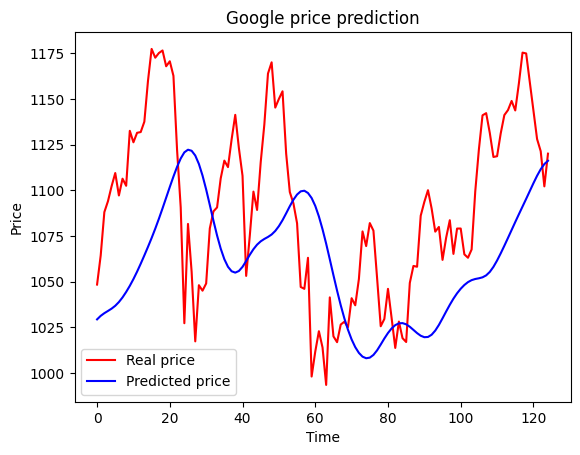

In [25]:
##visualize the prediction and real price
plt.plot(real_stock_price, color = 'red', label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')

plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()